In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
from torch.optim import Adam
from tqdm import tqdm
from dotenv import load_dotenv

from transformers import RobertaModel, RobertaTokenizer

In [2]:
load_dotenv()

True

In [3]:
wandb.login()

wandb: Currently logged in as: afifaniks. Use `wandb login --relogin` to force relogin


True

In [4]:
def load_dataframe(path: str) -> pd.DataFrame:
    return pd.read_csv(path)

In [5]:
def clean_data(df):
    df['text'] = df['text'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')
    df["text"] = df['text'].str.replace(" +", " ", regex=True)

    return df
    
def prepare_dataframe(df: pd.DataFrame, minimum_contribution = 0) -> pd.DataFrame:
    developers = df["assignees"].value_counts()
    filtered_developers = developers.index[developers >= minimum_contribution]
    df = df[df["assignees"].isin(filtered_developers)]

    df["text"] = df.apply(lambda x: str(x["issue_title"]) + "\n" + str(x["issue_body"]), axis=1)
    df["owner_id"] = pd.factorize(df["assignees"])[0]

    min_length = 15
    df = df[df["text"].str.len().gt(min_length)]

    return df

In [6]:
data_path = "/home/mdafifal.mamun/notebooks/triagerX/notebook/data/openj9_issues_cleaned.csv"

df = load_dataframe(data_path)
df = prepare_dataframe(df)
df = clean_data(df)

In [7]:
df["assignees"].value_counts()

assignees
DanHeidinga      798
mpirvu           695
0xdaryl          537
pshipton         503
fjeremic         477
keithc-ca        403
knn-k            188
dsouzai          153
andrewcraik      146
JasonFengJ9      143
gacholio         138
dmitripivkine    131
babsingh          69
vijaysun-omr      61
hzongaro          61
ymanton           53
gita-omr          47
ChengJin01        45
fengxue-IS        44
jdmpapin          42
tajila            42
amicic            41
charliegracie     40
joransiu          34
llxia             34
a7ehuo            33
Name: count, dtype: int64

In [8]:
df.head()

,Unnamed: 0,issue_number,issue_url,issue_title,issue_body,issue_state,creator,comments,assignees,text,owner_id
0,0,10,https://github.com/eclipse-openj9/openj9/pull/10,Update README.md with proper AdoptOpenJDK link,"Also remove the the coming soon reference, sin...",closed,pshipton,NaN,charliegracie,Update README.md with proper AdoptOpenJDK link...,0
1,1,15,https://github.com/eclipse-openj9/openj9/pull/15,Refactor and clean up CodeCacheManager,- Change invocation parameters of superclass c...,closed,lmaisons,<comment><user>lmaisons</user><body>This has a...,0xdaryl,Refactor and clean up CodeCacheManager\n- Chan...,1
2,2,17,https://github.com/eclipse-openj9/openj9/pull/17,WIP Add support for function pointers in Panama,When invoking a native function (with Panama) ...,closed,tajila,<comment><user>tajila</user><body>Thanks for t...,DanHeidinga,WIP Add support for function pointers in Panam...,2
3,3,22,https://github.com/eclipse-openj9/openj9/pull/22,fix illegal-access behaviour,fix illegal-access behaviour\r\n\r\nThis is th...,closed,tajila,<comment><user>DanHeidinga</user><body>@tajila...,DanHeidinga,fix illegal-access behaviour\nfix illegal-acce...,2
4,4,24,https://github.com/eclipse-openj9/openj9/issue...,Enable a travis.ci-based PR build for linux x8...,Build a basic PR build based off the linux_x86...,closed,DanHeidinga,<comment><user>mgaudet</user><body>This has be...,DanHeidinga,Enable a travis.ci-based PR build for linux x8...,2


In [9]:
print(len(df))

4958


<Axes: ylabel='count'>

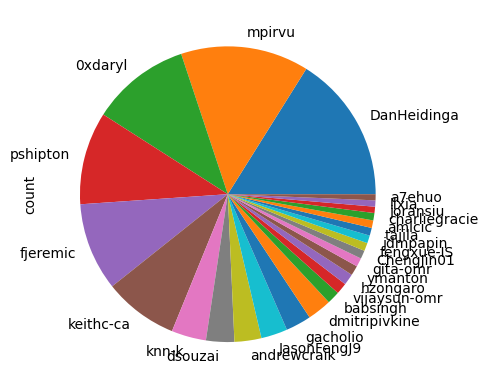

In [10]:
df["assignees"].value_counts().plot(kind="pie")

In [11]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=22),
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

3966 496 496


/home/mdafifal.mamun/miniconda3/envs/triagerx/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [12]:
df["assignees"].value_counts()

assignees
DanHeidinga      798
mpirvu           695
0xdaryl          537
pshipton         503
fjeremic         477
keithc-ca        403
knn-k            188
dsouzai          153
andrewcraik      146
JasonFengJ9      143
gacholio         138
dmitripivkine    131
babsingh          69
vijaysun-omr      61
hzongaro          61
ymanton           53
gita-omr          47
ChengJin01        45
fengxue-IS        44
jdmpapin          42
tajila            42
amicic            41
charliegracie     40
joransiu          34
llxia             34
a7ehuo            33
Name: count, dtype: int64

In [13]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer):
        self.tokenizer = tokenizer
        self.labels = [label for label in df['owner_id']]
        self.texts = [self.tokenizer(text,
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [14]:
class LBTLikeClassifier(nn.Module):
    def __init__(self, model_name: str, output_size, num_filters=256, bert_layers=4, embed_size=768, dropout = 0.1) -> None:
        super().__init__()
        self.base_model = RobertaModel.from_pretrained(model_name, output_hidden_states=True)
        filter_sizes = [3, 4, 5, 6]
        self.num_filters = num_filters
        self.bert_layers = bert_layers
        self.convs1 = nn.ModuleList([nn.Conv2d(self.bert_layers, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters + embed_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, input_ids, attention_mask):
        x = self.base_model(input_ids, attention_mask = attention_mask)
        hidden_states = x["hidden_states"][-self.bert_layers:]
        pooler_output = x["pooler_output"]
        x = torch.stack(hidden_states, dim=1)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        x = torch.cat(x, 1)
        x = torch.cat([pooler_output, x], 1)
        x = self.dropout(x)
        logit = self.fc1(x)

        return self.relu(x)


In [15]:
class Classifier(nn.Module):
    def __init__(self, model_name: str, output_size, embed_size=1024, dropout = 0.1) -> None:
        super().__init__()
        self.base_model = RobertaModel.from_pretrained(model_name, output_hidden_states=True)
        filter_sizes = [3, 4, 5, 6]
        num_filters = 256
        self._tokenizer = RobertaTokenizer.from_pretrained(model_name)
        self.convs1 = nn.ModuleList([nn.Conv2d(4, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters, output_size)
        self.relu = nn.ReLU()

    def forward(self, input_ids, attention_mask):
        x = self.base_model(input_ids, attention_mask = attention_mask)[2][-4:]
        x = torch.stack(x, dim=1)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)
        logit = self.fc1(x)  

        return self.relu(logit)
    
    def tokenizer(self) -> RobertaTokenizer:
        return self._tokenizer


In [16]:
def train(model, tokenizer, train_data, val_data, learning_rate, epochs, out_file, run, batch_size = 15):
    train, val = Dataset(train_data, tokenizer), Dataset(val_data, tokenizer)

    wandb.init(
        # Set the project where this run will be logged
        project="triager_x", 
        # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
        name=f"experiment_{run}", 
        # Track hyperparameters and run metadata
        config={
        "learning_rate": learning_rate,
        "architecture": "Roberta-CNN",
        "dataset": "openj9",
        "epochs": epochs,
    })
    

    train_dataloader = torch.utils.data.DataLoader(
        train, batch_size=batch_size, shuffle=True
    )
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=batch_size)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    best_loss = float("inf")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    if use_cuda:
        print("Using CUDA...")
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):
        print(f"Epoch: {epoch_num}")
        total_acc_train = 0
        total_loss_train = 0

        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input["attention_mask"].to(device)
            input_id = train_input["input_ids"].squeeze(1).to(device)

            output = model(input_id, mask)

            batch_loss = criterion(output, train_label.long())
            total_loss_train += batch_loss.item()

            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():

            for val_input, val_label in val_dataloader:

                val_label = val_label.to(device)
                mask = val_input["attention_mask"].to(device)
                input_id = val_input["input_ids"].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, val_label.long())
                total_loss_val += batch_loss.item()

                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc

        val_loss = total_loss_val / len(val_data)

        log = f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}"
        print(log)

        wandb.log({
            "train_acc": total_acc_train / len(train_data), 
            "train_loss": total_loss_train / len(train_data),
            "val_acc": total_acc_val / len(val_data),
            "val_loss": total_loss_val / len(val_data)
            })

        if val_loss < best_loss:
            print("Found new best model. Saving weights...")
            torch.save(model.state_dict(), out_file)
            best_loss = val_loss
    
    wandb.finish()

EPOCHS = 20
num_classes = len(df["assignees"].unique())
model = Classifier("roberta-base", num_classes, 768)
tokenizer = model.tokenizer()
LR = 1e-6

train(model, tokenizer, df_train, df_val, LR, EPOCHS, "teacher.pt", "base")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using CUDA...
Epoch: 0


100%|██████████| 265/265 [01:40<00:00,  2.64it/s]


Epochs: 1 | Train Loss:  0.205                 | Train Accuracy:  0.159                 | Val Loss:  0.187                 | Val Accuracy:  0.268
Found new best model. Saving weights...
Epoch: 1


100%|██████████| 265/265 [01:40<00:00,  2.64it/s]


Epochs: 2 | Train Loss:  0.175                 | Train Accuracy:  0.309                 | Val Loss:  0.169                 | Val Accuracy:  0.351
Found new best model. Saving weights...
Epoch: 2


100%|██████████| 265/265 [01:39<00:00,  2.65it/s]


Epochs: 3 | Train Loss:  0.162                 | Train Accuracy:  0.368                 | Val Loss:  0.162                 | Val Accuracy:  0.359
Found new best model. Saving weights...
Epoch: 3


100%|██████████| 265/265 [01:39<00:00,  2.66it/s]


Epochs: 4 | Train Loss:  0.153                 | Train Accuracy:  0.394                 | Val Loss:  0.155                 | Val Accuracy:  0.413
Found new best model. Saving weights...
Epoch: 4


100%|██████████| 265/265 [01:39<00:00,  2.66it/s]


Epochs: 5 | Train Loss:  0.146                 | Train Accuracy:  0.428                 | Val Loss:  0.151                 | Val Accuracy:  0.403
Found new best model. Saving weights...
Epoch: 5


100%|██████████| 265/265 [01:39<00:00,  2.66it/s]


Epochs: 6 | Train Loss:  0.140                 | Train Accuracy:  0.451                 | Val Loss:  0.147                 | Val Accuracy:  0.431
Found new best model. Saving weights...
Epoch: 6


100%|██████████| 265/265 [01:39<00:00,  2.66it/s]


Epochs: 7 | Train Loss:  0.134                 | Train Accuracy:  0.475                 | Val Loss:  0.144                 | Val Accuracy:  0.444
Found new best model. Saving weights...
Epoch: 7


100%|██████████| 265/265 [01:39<00:00,  2.66it/s]


Epochs: 8 | Train Loss:  0.130                 | Train Accuracy:  0.495                 | Val Loss:  0.142                 | Val Accuracy:  0.456
Found new best model. Saving weights...
Epoch: 8


100%|██████████| 265/265 [01:39<00:00,  2.66it/s]


Epochs: 9 | Train Loss:  0.126                 | Train Accuracy:  0.511                 | Val Loss:  0.141                 | Val Accuracy:  0.456
Found new best model. Saving weights...
Epoch: 9


100%|██████████| 265/265 [01:39<00:00,  2.66it/s]


Epochs: 10 | Train Loss:  0.122                 | Train Accuracy:  0.528                 | Val Loss:  0.139                 | Val Accuracy:  0.456
Found new best model. Saving weights...
Epoch: 10


100%|██████████| 265/265 [01:39<00:00,  2.66it/s]


Epochs: 11 | Train Loss:  0.119                 | Train Accuracy:  0.539                 | Val Loss:  0.139                 | Val Accuracy:  0.464
Found new best model. Saving weights...
Epoch: 11


100%|██████████| 265/265 [01:39<00:00,  2.66it/s]


Epochs: 12 | Train Loss:  0.115                 | Train Accuracy:  0.553                 | Val Loss:  0.137                 | Val Accuracy:  0.452
Found new best model. Saving weights...
Epoch: 12


100%|██████████| 265/265 [01:39<00:00,  2.66it/s]


Epochs: 13 | Train Loss:  0.112                 | Train Accuracy:  0.572                 | Val Loss:  0.136                 | Val Accuracy:  0.464
Found new best model. Saving weights...
Epoch: 13


100%|██████████| 265/265 [01:39<00:00,  2.66it/s]


Epochs: 14 | Train Loss:  0.108                 | Train Accuracy:  0.590                 | Val Loss:  0.135                 | Val Accuracy:  0.478
Found new best model. Saving weights...
Epoch: 14


100%|██████████| 265/265 [01:39<00:00,  2.66it/s]


Epochs: 15 | Train Loss:  0.106                 | Train Accuracy:  0.604                 | Val Loss:  0.136                 | Val Accuracy:  0.462
Epoch: 15


100%|██████████| 265/265 [01:39<00:00,  2.66it/s]


Epochs: 16 | Train Loss:  0.102                 | Train Accuracy:  0.617                 | Val Loss:  0.136                 | Val Accuracy:  0.460
Epoch: 16


100%|██████████| 265/265 [01:39<00:00,  2.66it/s]


Epochs: 17 | Train Loss:  0.099                 | Train Accuracy:  0.628                 | Val Loss:  0.135                 | Val Accuracy:  0.470
Found new best model. Saving weights...
Epoch: 17


100%|██████████| 265/265 [01:39<00:00,  2.66it/s]


Epochs: 18 | Train Loss:  0.096                 | Train Accuracy:  0.642                 | Val Loss:  0.134                 | Val Accuracy:  0.470
Found new best model. Saving weights...
Epoch: 18


100%|██████████| 265/265 [01:39<00:00,  2.66it/s]


In [ ]:
import random

for i in range(5):
    rand = random.randint(0, len(df_val))
    dx = df_val.iloc[rand]

    data = model.tokenizer()(dx["text"])
    ids, mask = data["input_ids"], data["attention_mask"]

    id = torch.tensor([ids]).cuda()
    m = torch.tensor([mask]).cuda()

    g = nn.Softmax(dim=1)

    print(dx["owner_id"], torch.argmax(g(model(id, m))))

2 tensor(2, device='cuda:0')
16 tensor(5, device='cuda:0')
1 tensor(1, device='cuda:0')
6 tensor(6, device='cuda:0')
8 tensor(1, device='cuda:0')
